In [1]:
import torch
from torchvision import datasets, transforms as T
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import torchsummary

from sklearn.model_selection import train_test_split

In [2]:
data_transforms = {
    'train': transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    'test': transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
#    'validation': transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
}

In [3]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_dir = '../data_augmented_new'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")

In [4]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [5]:
model_cnn = resnet18.to(device)

#model_cnn = models.resnet18().to(device)
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer = optim.SGD(model_cnn.parameters(), lr=0.1, momentum=0.9)
#lambda1 = lambda epoch:0.65**epoch
#schedular = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.00001)
 

In [6]:
train_loader, test_loader, validation_loader = dataloaders['train'], dataloaders['test'], dataloaders['validation']
train_acc=[]
train_loss=[]
validation_acc = []
validation_loss = []

def train_model(model, criterion, optimizer):
    running_loss = 0 
    running_corrects = 0 

    model.train()  # 모델을 학습 모드로 설정
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * running_corrects.double() /  len(train_loader.dataset)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    
    #validation
    
    val_loss = 0
    validation_corrects = 0
    
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        
        loss = criterion(outputs, labels)
        val_loss+=loss.item()*inputs.size(0)
        validation_corrects +=torch.sum(preds==labels.data)
    
    epoch_loss = val_loss/len(validation_loader.dataset)
    epoch_acc = 100* validation_corrects.double()/len(validation_loader.dataset)
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    validation_loss.append(epoch_loss)
    validation_acc.append(epoch_acc)
        
 
        

In [7]:
test_acc=[]
test_loss=[]

def test_model(model):
 
    best_acc = 0.0
    model.eval()   

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
 
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * running_corrects.double() / len(test_loader.dataset)


    if epoch_acc > best_acc:
        best_acc = epoch_acc

    print('test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()
    print('Best val Acc: {:4f}'.format(best_acc))
    test_acc.append(epoch_acc)
    test_loss.append(epoch_loss)
 
 
    return best_acc

In [8]:
num_epochs =  21

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    train_model(model_cnn, criterion, optimizer)
    best_acc = test_model(model_cnn)

Epoch 0/21
----------
train Loss: 12.9385 Acc: 43.4483
Validation Loss: 78.9816 Acc: 2.8571
test Loss: 1775.3527 Acc: 40.0000

Best val Acc: 40.000000
Epoch 1/21
----------
train Loss: 14.4363 Acc: 45.5172
Validation Loss: 13.5048 Acc: 51.4286
test Loss: 2.0395 Acc: 40.0000

Best val Acc: 40.000000
Epoch 2/21
----------
train Loss: 2.6789 Acc: 46.2069
Validation Loss: 17.5322 Acc: 0.0000
test Loss: 1.4354 Acc: 60.0000

Best val Acc: 60.000000
Epoch 3/21
----------
train Loss: 2.8957 Acc: 53.1034
Validation Loss: 9.6955 Acc: 8.5714
test Loss: 1.5218 Acc: 60.0000

Best val Acc: 60.000000
Epoch 4/21
----------
train Loss: 1.4419 Acc: 53.7931
Validation Loss: 9.4662 Acc: 48.5714
test Loss: 0.7190 Acc: 40.0000

Best val Acc: 40.000000
Epoch 5/21
----------
train Loss: 1.4966 Acc: 49.6552
Validation Loss: 7.4719 Acc: 51.4286
test Loss: 2.0146 Acc: 40.0000

Best val Acc: 40.000000
Epoch 6/21
----------
train Loss: 1.1643 Acc: 53.1034
Validation Loss: 10.2641 Acc: 5.7143
test Loss: 0.7858 Acc:

In [11]:
epochs = list(range(21))

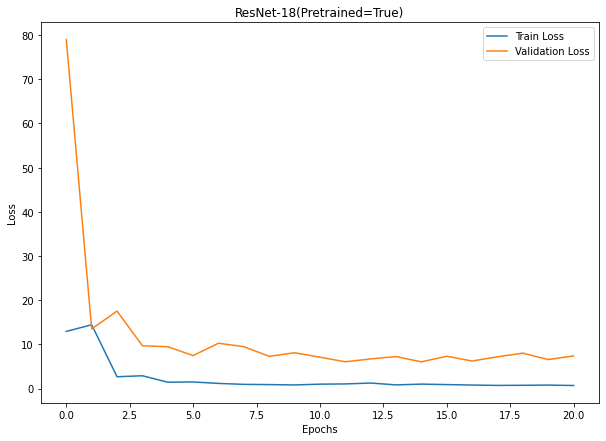

In [12]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('ResNet-18(Pretrained=True)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()